In [2]:
import pandas as pd

In [3]:
# Get data from file, or scrape if not present
df = pd.DataFrame()
try:
    df = df.from_csv('all_crime.csv')
except FileNotFoundError:
    from datetime import date
    start_date = date(2015, 8, 1)
    today = date.today()
    end_date = date(today.year, today.month - 2, 1)
    dates = pd.date_range(start=start_date, end=end_date, freq='MS')
    for date in dates:
        url = 'https://www.police.uk/gloucestershire/CA1/crime/{}/data/'.format(date.strftime("%Y-%m"))
        mdf = pd.read_json(url)
        mdf['date'] = date
        df = df.append(mdf)
    # Save it
    df.to_csv('all_crime.csv')

/home/seb/.local/share/virtualenvs/stroudcrime/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.


In [32]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

Text(0.5, 0.98, 'Most common crimes, normalised to same scale')

<Figure size 1440x1280 with 0 Axes>

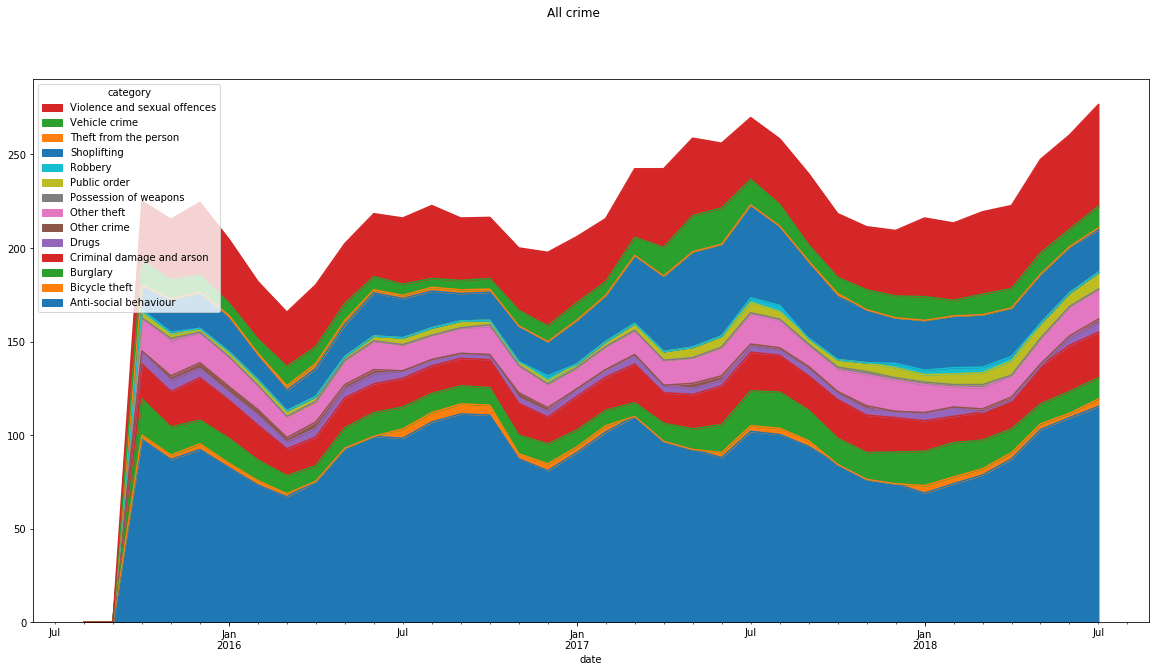

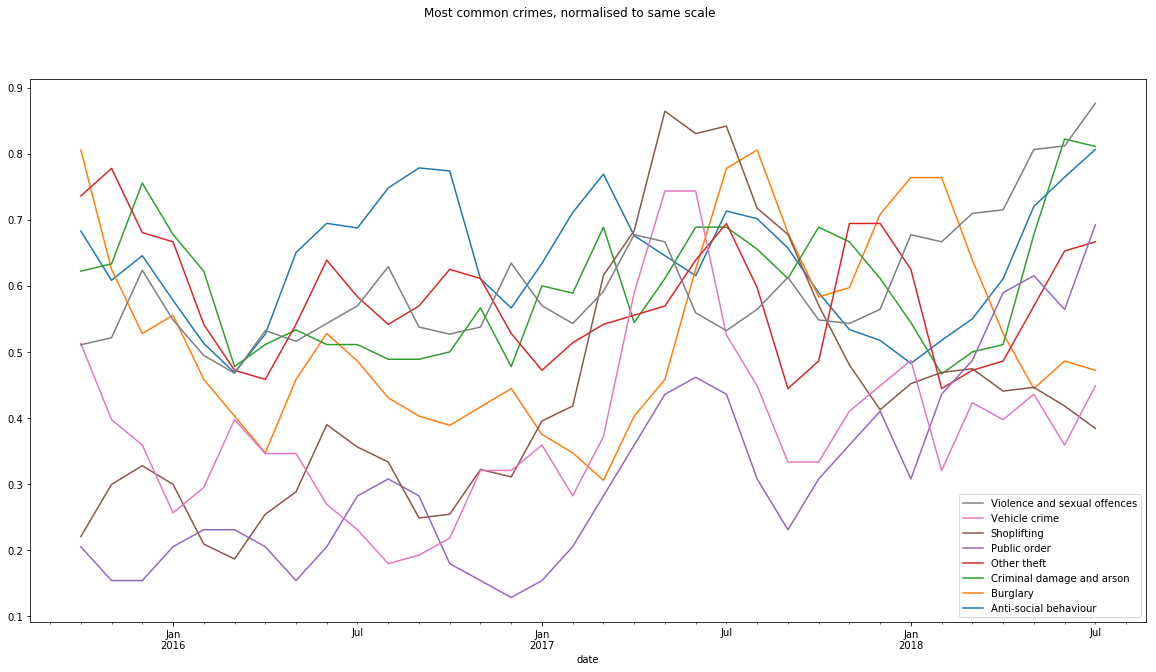

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

# Count incidents by month and category
grouped = df.groupby(['category', 'date']).agg('count').reset_index(level=0).pivot_table(
    index='date', columns='category', values='location')

# Restrict to categories with more data
top_categories = ["Anti-social behaviour", "Burglary", "Criminal damage and arson", 
                  "Other theft", "Public order", "Shoplifting", "Vehicle crime", "Violence and sexual offences"]

# Normalise to maximum as baseline
df2 = pd.DataFrame()
for col in grouped.columns:
    df2[col] = grouped[col]/grouped[col].max()

# Plot them
from matplotlib.pyplot import figure
figure(num=None, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')

plt.rcParams["figure.figsize"] = (20,10)
grouped.rolling(3).mean().plot.area(legend='reverse')
plt.suptitle("All crime")

ax = df2[top_categories].rolling(3).mean().plot(legend='reverse')
plt.suptitle("Most common crimes, normalised to same scale")


In [11]:
df2.head()

,Anti-social behaviour,Burglary,Criminal damage and arson,Other theft,Public order,Shoplifting,Vehicle crime,Violence and sexual offences
date,,,,,,,,
2015-08-01,0.867133,1.000000,0.566667,0.666667,0.307692,0.186441,0.538462,0.564516
2015-09-01,0.538462,0.708333,0.566667,0.875000,0.153846,0.220339,0.269231,0.322581
2015-10-01,0.643357,0.708333,0.733333,0.666667,0.153846,0.254237,0.730769,0.645161
2015-11-01,0.643357,0.458333,0.600000,0.791667,0.153846,0.423729,0.192308,0.596774
2015-12-01,0.650350,0.416667,0.933333,0.583333,0.153846,0.305085,0.153846,0.629032
